In [409]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Data Acquisition

In [16]:
import kagglehub
from kagglehub import  KaggleDatasetAdapter

# Download latest version
dataset_handle = "aunanya875/suicidal-tweet-detection-dataset"
path = "Suicide_Ideation_Dataset(Twitter-based).csv"

loaded_lf = kagglehub.dataset_load(
    KaggleDatasetAdapter.POLARS,
    dataset_handle,
    path,
)

In [28]:
loaded_lf.head().collect()

Tweet,Suicide
str,str
"""making some lunch""","""Not Suicide post"""
"""@Alexia You want his money.""","""Not Suicide post"""
"""@dizzyhrvy that crap took me f…","""Potential Suicide post """
"""@jnaylor #kiwitweets Hey Jer! …","""Not Suicide post"""
"""Trying out &quot;Delicious Lib…","""Not Suicide post"""


# Data Preprocessing & Representation

Null values handling

In [18]:
loaded_lf.null_count().collect()

Tweet,Suicide
u32,u32
2,0


In [21]:
non_null_lf = loaded_lf.drop_nulls()

print("New shape:", non_null_lf.collect().shape)

New shape: (1785, 2)


Tokenization

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000
PADDED_SEQ_SIZE = 120
OOV_TOKEN = "<OOV>"

In [37]:
X_col = "Tweet"

In [39]:
tokenizer = Tokenizer(VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(non_null_lf.collect()[X_col])

In [40]:
X_seq = tokenizer.texts_to_sequences(non_null_lf.collect()[X_col])
padded_X_seq = pad_sequences(X_seq, maxlen=PADDED_SEQ_SIZE)

In [51]:
non_null_lf.with_columns(
    pl.Series("Tweet Sequence", padded_X_seq),
).head().collect()

Tweet,Suicide,Tweet Sequence
str,str,"array[i32, 120]"
"""making some lunch""","""Not Suicide post""","[0, 0, … 963]"
"""@Alexia You want his money.""","""Not Suicide post""","[0, 0, … 328]"
"""@dizzyhrvy that crap took me f…","""Potential Suicide post ""","[0, 0, … 208]"
"""@jnaylor #kiwitweets Hey Jer! …","""Not Suicide post""","[0, 0, … 964]"
"""Trying out &quot;Delicious Lib…","""Not Suicide post""","[0, 0, … 520]"


Check classes balancing

In [4]:
y_col = "Suicide"

In [22]:
from collections import Counter

label_count = Counter(non_null_lf.collect()[y_col])

for index, label in enumerate(label_count):
    print(f"Class {index}: {label} - {label_count[label]} observations")

Class 0: Not Suicide post - 1126 observations
Class 1: Potential Suicide post  - 659 observations


Convert `Suicide` variable to Categorical type

In [23]:
categorical_lf = non_null_lf.with_columns(
    pl.all().exclude(y_col),
    pl.col(y_col).cast(pl.Categorical),
)

categorical_lf.head().collect()

Tweet,Suicide
str,cat
"""making some lunch""","""Not Suicide post"""
"""@Alexia You want his money.""","""Not Suicide post"""
"""@dizzyhrvy that crap took me f…","""Potential Suicide post """
"""@jnaylor #kiwitweets Hey Jer! …","""Not Suicide post"""
"""Trying out &quot;Delicious Lib…","""Not Suicide post"""


In [24]:
labels = categorical_lf.select(
    pl.col(y_col).cat.get_categories()
).collect()[y_col].to_list()

labels

['Not Suicide post', 'Potential Suicide post ']

In [30]:
physical_categorical_lf = categorical_lf.select(
    pl.all().exclude(y_col),
    pl.col(y_col).to_physical(),
)

physical_categorical_lf.head().collect()

Tweet,Suicide
str,u32
"""making some lunch""",0
"""@Alexia You want his money.""",0
"""@dizzyhrvy that crap took me f…",1
"""@jnaylor #kiwitweets Hey Jer! …",0
"""Trying out &quot;Delicious Lib…",0


One Hot Encoding

In [48]:
from tensorflow.keras.utils import to_categorical

X = padded_X_seq
y = to_categorical(physical_categorical_lf.select(y_col).collect())

X.shape, y.shape

((1785, 120), (1785, 2))

Train - Test Split

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train dataset shape:", X_train.shape, y_train.shape)
print("Test dataset shape:", X_test.shape, y_test.shape)

Train dataset shape: (1428, 120) (1428, 2)
Test dataset shape: (357, 120) (357, 2)


# Modelization

In [428]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention, Dense, Embedding, GlobalAveragePooling1D, Input, LSTM

Model Hyperparameters

In [429]:
embedding_dim = 64
dense_1_n_units = 128
outputs_dim = len(labels)

Model layers

In [430]:
inputs = Input((PADDED_SEQ_SIZE,))
embedding = Embedding(VOCAB_SIZE, embedding_dim)(inputs)

encoder = LSTM(embedding_dim, return_sequences=True)(embedding)
attention = Attention()([encoder, encoder])
pooling = GlobalAveragePooling1D()(attention)

dense_1 = Dense(dense_1_n_units)(pooling)
outputs = Dense(outputs_dim, activation="softmax")(dense_1)

Create Model

In [431]:
suicidal_tweet_detector = Model(inputs, outputs)
suicidal_tweet_detector.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_72        │ (None, 120, 64)   │    640,000 │ input_layer_72[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ (None, 120, 64)   │     33,024 │ embedding_72[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_78        │ (None, 120, 64)   │          0 │ lstm_52[0][0],    │
│ (Attention)         │                   │            │ lstm_52[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention_78[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 2)         │        258 │ dense_120[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 681,602 (2.60 MB)

 Trainable params: 681,602 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [432]:
suicidal_tweet_detector.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
)

Training parameters

In [433]:
n_epochs = 5
training_batch_size = 32
validation_split = 0.1

Train model

In [434]:
history = suicidal_tweet_detector.fit(X_train, y_train, epochs=n_epochs, batch_size=training_batch_size, validation_split=validation_split)

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6346 - loss: 0.6492 - val_accuracy: 0.6364 - val_loss: 0.6492
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6625 - loss: 0.6308 - val_accuracy: 0.7762 - val_loss: 0.4721
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8198 - loss: 0.4458 - val_accuracy: 0.8531 - val_loss: 0.3807
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8865 - loss: 0.2985 - val_accuracy: 0.9091 - val_loss: 0.2479
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9118 - loss: 0.2416 - val_accuracy: 0.9301 - val_loss: 0.2055


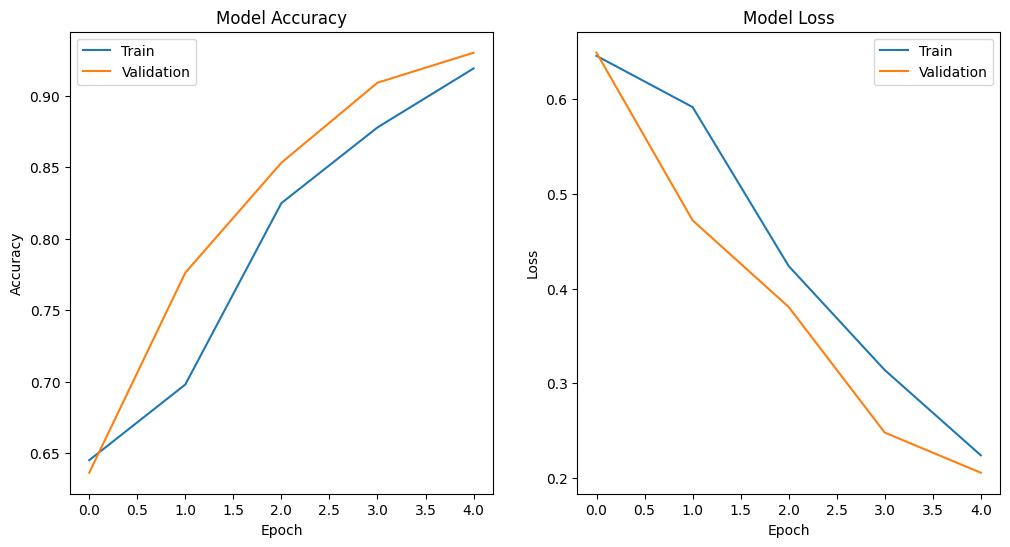

In [435]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()

Evaluate model

In [436]:
loss, accuracy = suicidal_tweet_detector.evaluate(X_test, y_test, verbose=0)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.25323450565338135
Test Accuracy: 0.9047619104385376


In [448]:
y_pred = suicidal_tweet_detector.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [449]:
expected = np.argmax(y_test, axis=1)
predicted = np.argmax(y_pred, axis=1)

In [450]:
from sklearn.metrics import f1_score

score = f1_score(expected, predicted)
print("F1 Score:", score)

F1 Score: 0.8776978417266187


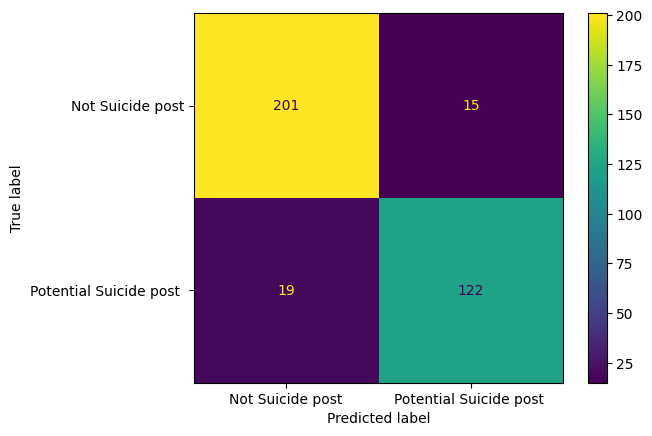

In [451]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(expected, predicted, display_labels=labels)
plt.show()

In [447]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(expected, predicted, target_names=labels))

Classification Report:
                         precision    recall  f1-score   support

       Not Suicide post       0.91      0.93      0.92       216
Potential Suicide post        0.89      0.87      0.88       141

               accuracy                           0.90       357
              macro avg       0.90      0.90      0.90       357
           weighted avg       0.90      0.90      0.90       357



Remarque :

Le modèle privilégie les faux négatifs aux faux positifs. Ceci constitue un défaut au vu du risque de considérer plus de cas suicidaires comme non suicidaires au lieu de l'inverse.

Ceci peut être dû au manque d'équilibre entre les classes dans le jeu de données.

# Model Saving

Setup backup path

In [441]:
base_folder_path = "/gdrive/MyDrive/ESTIAM/E5/AI-ML-Model-Design/"
backup_folder_path = f"{base_folder_path}/Exam-Model-Backup"
model_file_path = f"{backup_folder_path}/suicidal_tweet_detector.keras"
tokenizer_file_path = f"{backup_folder_path}/tokenizer.json"

In [442]:
from google.colab import drive
drive.mount('/gdrive')

!mkdir -p {backup_folder_path}

Mounted at /gdrive


Save tokenizer (Representation)

In [443]:
import json

with open(tokenizer_file_path, "w") as tokenizer_file:
    tokenizer_json = tokenizer.to_json()
    tokenizer_file.write(json.dumps(tokenizer_json, indent=2))

Save model

In [444]:
import tensorflow as tf

suicidal_tweet_detector.save(model_file_path)

In [445]:
!ls {backup_folder_path}

suicidal_tweet_detector.keras  tokenizer.json
